# Dataset

In [1]:
import sys
sys.path.append('../elpv-dataset/utils')
from elpv_reader import load_dataset
images, probs, types = load_dataset()
print(f'images: {images.shape}, probabilities: {probs.shape}, types: {types.shape}\n')

images: (2624, 300, 300), probabilities: (2624,), types: (2624,)



# Feature extraction - SIFT/KAZE/ORB/BRISK

In [3]:
import numpy as np
import cv2
from tqdm import tqdm

In [4]:
def extract_features(images, probs, method):
    if method == 'sift':
        extractor = cv2.SIFT_create()
        description = 'SIFT'
    elif method == 'kaze':
        extractor = cv2.KAZE_create()
        description = 'KAZE'
    elif method == 'orb':
        extractor = cv2.ORB_create()
        description = 'ORB'
    elif method == 'brisk':
        extractor = cv2.BRISK_create()
        description = 'BRISK'
    
    # list of descriptors for each image
    descriptors_list = [extractor.detectAndCompute(i, None)[1] for i in tqdm(images, desc=f'Extracting {description} descriptors', colour="green")]

    # remove label values where no descriptors were found
    invalid_indices = [idx for idx, i in enumerate(descriptors_list) if i is None]
    new_y = np.delete(probs, invalid_indices)

    # descriptors from all images into one array
    all_descriptors = np.vstack([i for i in descriptors_list if i is not None])

    return descriptors_list, new_y, all_descriptors

# Global descriptor - VLAD

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [6]:
def get_vlad_vectors(k, all_descriptors, descriptors_list):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(all_descriptors)
    vlad_vectors = []
    pca = PCA(whiten=True)
    for descriptors in descriptors_list:
        if descriptors is None:
            continue

        cluster_assignments = kmeans.predict(descriptors)
        vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

        for idx, cluster_idx in enumerate(cluster_assignments):
            vlad_vector[cluster_idx] += (descriptors[idx] - kmeans.cluster_centers_[cluster_idx])

        # Power normalization
        p = 0.5
        vlad_vector = np.sign(vlad_vector) * np.abs(vlad_vector) ** p

        vlad_vector = normalize(vlad_vector, norm='l2', axis=1)  # Normalize each row independently

        vlad_vectors.append(vlad_vector.flatten())
        
    all_vlad_vectors = np.vstack(vlad_vectors)
    all_vlad_vectors = pca.fit_transform(all_vlad_vectors)
    all_vlad_vectors = normalize(all_vlad_vectors, norm='l2', axis=1)
    
    return all_vlad_vectors

# Classifier

In [7]:
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import class_weight
from collections import Counter
import matplotlib.pyplot as plt

#### Preparing train and test data

In [9]:
from imblearn.over_sampling import SMOTE

def prepare_data(vlad_vectors, filtered_descriptors):
    X = np.vstack(vlad_vectors)
    y = filtered_descriptors

    thresholds = [0, 0.33, 0.66, 1.0]
    y_classes = [sum(1 for t in thresholds if value >= t) for value in y]

    X_train, X_test, y_train, y_test = train_test_split(X, y_classes, test_size=0.25, random_state=42, stratify=y_classes)

    sm = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

    # Distribution of classes in train and test sets
    print(f'Training set class distribution: {Counter(y_train)}')
    print(f'Test set class distribution: {Counter(y_test)}')

    # Handling Class Imbalance
    # Compute class weights
    unique_classes = np.array([1, 2, 3, 4])
    weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=y_train)
    class_weights_dict = {cls: weight for cls, weight in zip(unique_classes, weights)}
    
    return X_train, X_test, y_train, y_test, class_weights_dict, X_train_resampled, y_train_resampled


#### Five-fold cross-validation to select the best C

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def get_best_C(X_train, y_train, class_weights_dict):
    # range of C values to test
    # C_values = np.logspace(-4, 4, 10)
    C_values = np.linspace(0.001, 1, 20)

    # Create a dictionary to store average cross-validation scores for each C value
    avg_scores = {}

    # Loop over C values and perform five-fold cross-validation
    for C in C_values:
        svc = LinearSVC(C=C, dual=True, max_iter=10000, class_weight=class_weights_dict)

        # Obtain the five cross-validation scores using accuracy as a metric
        scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')

        # average score for this C value
        avg_scores[C] = scores.mean()

    best_C = max(avg_scores, key=avg_scores.get)

    print(f"Best C value: {best_C}")
    print(f"Average cross-validation score for best C: {avg_scores[best_C]}")
    
    return best_C

def get_best_params_SVM(kernel, X_train, y_train, class_weights_dict):
    if kernel == 'linear':
        param_grid = {
            'C': np.linspace(0.001, 1, 20),
            'class_weight': [None, class_weights_dict],
        }
        grid_search = GridSearchCV(LinearSVC(dual=True, max_iter=10000), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
    elif kernel == 'rbf':
        param_grid = {
            'C': np.logspace(-3, 3, 7),
            'gamma': np.logspace(-3, 3, 7),
            'class_weight': [None, class_weights_dict],
        }
        #grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
        rand_search = RandomizedSearchCV(SVC(kernel='rbf'), param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
        rand_search.fit(X_train, y_train)
        best_params = rand_search.best_params_
    

    print(f"Best parameters for {kernel} SVM:", best_params)
    return best_params


#### Train the SVM with class weights and display results

In [11]:
def train_test_SVM(mode, best_C, class_weights_dict, X_train, y_train, X_test, y_test, gamma=None):    
    if mode == 'linear':
        clf = LinearSVC(C=best_C, dual=True, max_iter=10000, class_weight=class_weights_dict)
        description = 'Linear'
    elif mode == 'rbf':
        description = 'RBF'
        clf = SVC(kernel='rbf', C=best_C, gamma=gamma, class_weight=class_weights_dict)

    
    clf.fit(X_train, y_train)

    # Predictions and evaluation
    predictions = clf.predict(X_test)
    print(f'{description} SVM Results:')
    print(classification_report(y_test, predictions))

    conf_matrix = confusion_matrix(y_test, predictions)
    print(f'Confusion Matrix:{conf_matrix}\n')

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
    disp.plot()
    plt.show()

## Linear SVM & Non-linear Radial Basis Function (RBF) SVM

Extracting SIFT descriptors: 100%|██████████| 2624/2624 [00:20<00:00, 127.64it/s]


Training set class distribution: Counter({1: 1131, 4: 526, 2: 221, 3: 79})
Test set class distribution: Counter({1: 377, 4: 175, 2: 74, 3: 27})
Best parameters for linear SVM: {'C': 1.0, 'class_weight': None}
Linear SVM Results:
              precision    recall  f1-score   support

           1       0.74      0.56      0.64       377
           2       0.20      0.32      0.25        74
           3       0.12      0.19      0.15        27
           4       0.48      0.55      0.51       175

    accuracy                           0.52       653
   macro avg       0.38      0.41      0.39       653
weighted avg       0.58      0.52      0.54       653

Confusion Matrix:[[213  56  21  87]
 [ 30  24   6  14]
 [  7   9   5   6]
 [ 37  32   9  97]]



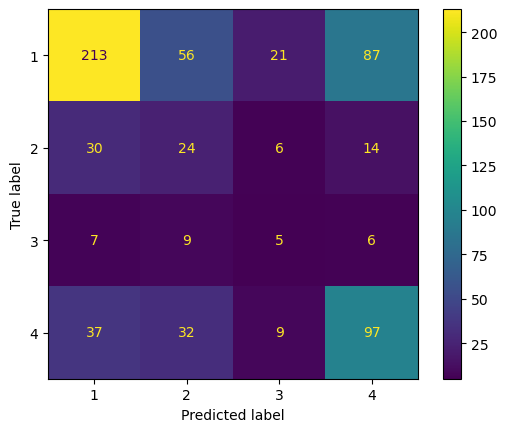

Fitting 5 folds for each of 10 candidates, totalling 50 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [12]:
feature_ex_methods = ['sift', 'kaze', 'orb', 'brisk']

for method in feature_ex_methods:
    descriptors_list, filtered_descriptors, all_descriptors = extract_features(images, probs, method)
    vlad_vectors = get_vlad_vectors(6, all_descriptors, descriptors_list)
    
    X_train, X_test, y_train, y_test, class_weights_dict, X_train_resampled, y_train_resampled = prepare_data(vlad_vectors, filtered_descriptors)
    
    #best_C = get_best_C(X_train, y_train, class_weights_dict)
    
#     train_test_SVM('linear', best_C, class_weights_dict, X_train_resampled, y_train_resampled, X_test, y_test)
    
#     train_test_SVM('rbf', best_C, class_weights_dict, X_train, y_train, X_test, y_test)
    
    best_params_linear = get_best_params_SVM('linear', X_train_resampled, y_train_resampled, class_weights_dict)
    train_test_SVM('linear', best_params_linear['C'], class_weights_dict, X_train_resampled, y_train_resampled, X_test, y_test)
    
    best_params_rbf = get_best_params_SVM('rbf', X_train_resampled, y_train_resampled, class_weights_dict)
    train_test_SVM('rbf', best_params_rbf['C'], class_weights_dict, X_train_resampled, y_train_resampled, X_test, y_test, gamma=best_params_rbf['gamma'])
    